In [57]:
import numpy as np
import pandas as pd
from scipy.stats import beta
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score

# Bayesian-style metric updates

Suppose we have a trained and validated classifier that we are running in a live environment.

The number of instances requiring classification varies per day.

Our classifier makes a number of predictions per day (on previously unseen data).

At the end of each day the actual groundtruth labels become available.

We want to monitor and control the predicted versus actual labels using different metrics.


## [1] Simulate classifier output by assuming Recall and Precision

In [4]:
n_days = 10
n_instances = np.random.randint(low=40, high=80, size=10)
balance_low, balance_high = .3, .5
Recall_assumed = .8
Precision_assumed = .6
n_predicted_correctly = np.array([int(x) for x in (balance_low + (balance_high - balance_low)*np.random.rand(n_days,))*n_instances])
Ls = pd.DataFrame(index=pd.date_range(start='2019-01-01', freq='D', periods=n_days), \
                  data=np.vstack((n_instances, n_predicted_correctly)).T, \
                  columns=['instances', 'actual_positives'])
Ls['actual_negatives'] = Ls['instances'] - Ls['actual_positives']
Ls['true_positives'] = (Recall_assumed * Ls['actual_positives']).astype(int)
Ls['false_negatives'] = Ls['actual_positives'] - Ls['true_positives']
Ls['false_positives'] = (Ls['true_positives'] * (1/Precision_assumed - 1)).astype(int)
Ls['true_negatives'] = Ls['actual_negatives'] - Ls['false_positives']

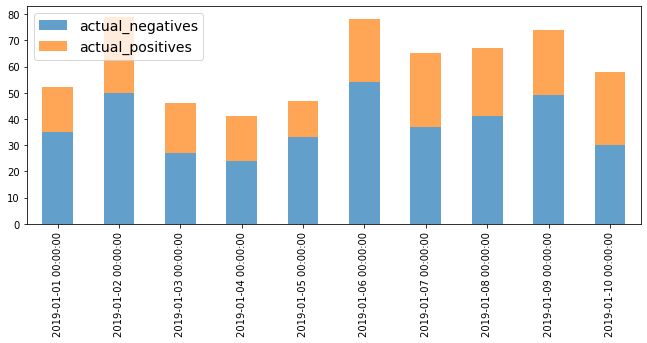

In [5]:
Ls[['actual_negatives','actual_positives']].plot.bar(width=.5, figsize=(11,4), stacked=True, alpha=.7)
plt.legend(fontsize=14)

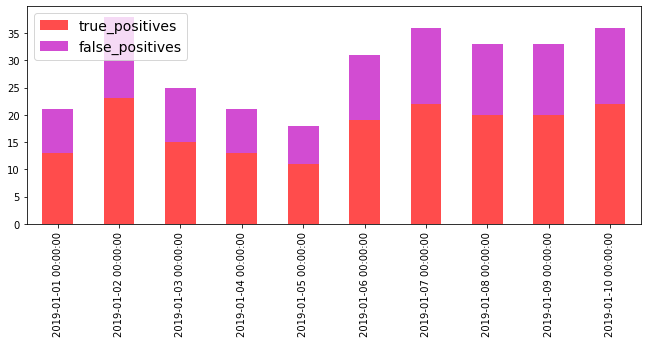

In [6]:
Ls[['true_positives','false_positives']].plot.bar(width=.5, figsize=(11,4), color=['r','m'], stacked=True, alpha=.7)
plt.legend(fontsize=14)

In [7]:
Ls[:2]

,instances,actual_positives,actual_negatives,true_positives,false_negatives,false_positives,true_negatives
2019-01-01,52,17,35,13,4,8,27
2019-01-02,79,29,50,23,6,15,35


## [2] Simulate classifier scores via assumed beta distributions

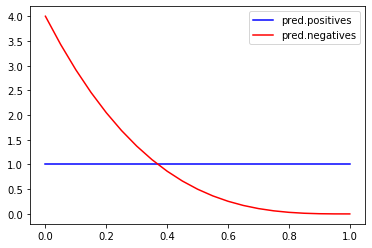

In [12]:
# Show shape of Beta dists:
n = 21
probs = np.linspace(0,1,n)
rv0 = beta(1, 1)
rv1 = beta(1, 4)
predicted_positives = [rv0.pdf(x) for x in probs]
predicted_negatives = [rv1.pdf(x) for x in probs]
plt.plot(probs, predicted_positives, 'b-', label='pred.positives')
plt.plot(probs, predicted_negatives, 'r-', label='pred.negatives')
plt.legend()
plt.xlabel('probability (-)')
plt.ylabel('density')

In [45]:
# Draw scores for positives and negatives, for assumed prevalence/balance:
def simulate_scores(beta_param_pos, beta_param_neg, balance=.3, n_samples=1000):
    """
        n_samples is number of instances
        balance = P / (P + N), prevalance of positives
    """
    n_P = int(y * n_samples)  # number of actual positives
    n_N = n_samples - n_P
    rv0 = beta(beta_param_pos, 1)
    P_predicted = rv0.rvs(n_P)  # predicted scores for positives
    rv1 = beta(1, beta_param_neg)
    N_predicted = rv1.rvs(n_N)  # idem for negatives
    scores_predicted = np.hstack((P_predicted, N_predicted))
    labels_groundtruth = np.hstack((np.ones_like(P_predicted), np.zeros_like(N_predicted)))
    return labels_groundtruth, scores_predicted

In [47]:
# Example computation static metrics:
gt_labels, pred_scores = simulate_scores(1, 4)
AUC = roc_auc_score(gt_labels, pred_scores)
FPR, TPR, ROC_thresholds = roc_curve(gt_labels, pred_scores)
Prec, Rec, PRC_thresholds = precision_recall_curve(gt_labels, pred_scores)
avg_Precision = average_precision_score(gt_labels, pred_scores)
print(AUC)

0.7941428571428573


### Monte Carlo simulation on beta params for AUC at desired balance

(1.0, 5.0, 1.0, 5.0)

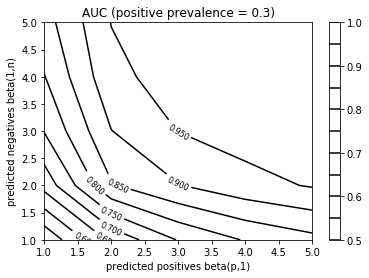

In [126]:
balance = .3  # proportion positives
max_param = 6

AUC_ = np.empty((max_param-1, max_param-1))
for p,n in product(range(1,max_param), range(1,max_param)):
    gt_labels, pred_scores = simulate_scores(p, n, balance=balance, n_samples=10000)
    AUC_[p-1, n-1] = roc_auc_score(gt_labels, pred_scores)

P, N = np.meshgrid(range(1,max_param), range(1,max_param))
Q = plt.contour(P, N, AUC_, 10, colors='black')#cmap='RdGy')
plt.clabel(Q, inline=True, fontsize=8)
#plt.imshow(AUC_, extent=[1, 5, 1, 5])
plt.colorbar()
plt.title('AUC (positive prevalence = %.1f)' % balance)
plt.xlabel('predicted positives beta(p,1)')
plt.ylabel('predicted negatives beta(1,n)')
plt.axis(aspect='image')

### Compute daily precisions and Beta-Binomial estimate of precision

In [85]:
Ls['day_precision'] = Ls['true_positives'] / (Ls['true_positives'] + Ls['false_positives'])

In [86]:
Ls

,instances,actual_positives,actual_negatives,true_positives,false_negatives,false_positives,true_negatives,day_precision
2019-01-01,64,26,38,20,6,13,25,0.606061
2019-01-02,52,21,31,16,5,10,21,0.615385
2019-01-03,66,27,39,21,6,14,25,0.600000
2019-01-04,77,24,53,19,5,12,41,0.612903
2019-01-05,75,29,46,23,6,15,31,0.605263
2019-01-06,41,12,29,9,3,6,23,0.600000
2019-01-07,43,19,24,15,4,10,14,0.600000
2019-01-08,54,21,33,16,5,10,23,0.615385
2019-01-09,77,34,43,27,7,18,25,0.600000
2019-01-10,56,27,29,21,6,14,15,0.600000
